## Instructions:Your final report should be written up in a Jupyter notebook.  It should be posted to a public Github repo as an ipynb AND it should be saved as an html file and submitted to this assignment via courseworks.  Please include the link to your Github repo in this html file.

### Your report should include the following information:

### 1. Visualize brain tumor images that demonstrate when images have tumors and when they do not have tumors.

In [0]:
import sys
import time
import cv2
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import os
import zipfile
import pandas as pd

from skimage.transform import resize
from sklearn.model_selection import train_test_split

from tensorflow.python.keras.utils import np_utils
from tensorflow.python.keras.models import Sequential, Model
from tensorflow.python.keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization
from tensorflow.python.keras.layers.convolutional import Conv2D, MaxPooling2D 
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from tensorflow.keras.applications  import VGG19, ResNet50, InceptionV3

In [17]:
!unzip brain_tumor_dataset.zip  

Archive:  brain_tumor_dataset.zip
replace brain_tumor_dataset/no/1 no.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [0]:
base_path = 'brain_tumor_dataset'
category = ['yes','no']

filenames =[]
for prediction in category:
  image_folder = os.path.join(base_path, prediction)
  file_names = os.listdir(image_folder)
  full_path = [os.path.join(image_folder,file_name) for file_name in file_names]
  filenames.append(full_path)

In [0]:
from keras.preprocessing import image
import numpy as np
from PIL import Image

def load_image(img_path):
        img = Image.open(img_path).convert("RGB").resize((224,224)) # import image, make sure it's RGB and resize to height and width you want.
        img = (np.float32(img)-np.float32(img).min())/(np.float32(img).max()-np.float32(img).min()) # min max transformation
        img=img.reshape((224,224,3)) # Create final shape as array with correct dimensions for Keras
        return img

preprocessed_image_data=list(map(load_image, filenames[0]+filenames[1])) 

X= np.array(preprocessed_image_data)


In [0]:
from itertools import repeat
from keras.preprocessing import image
import numpy as np
from PIL import Image
yes=list(repeat("yes", 155))
no=list(repeat("no", 98))
y_labels = yes+no
y=pd.get_dummies(y_labels)

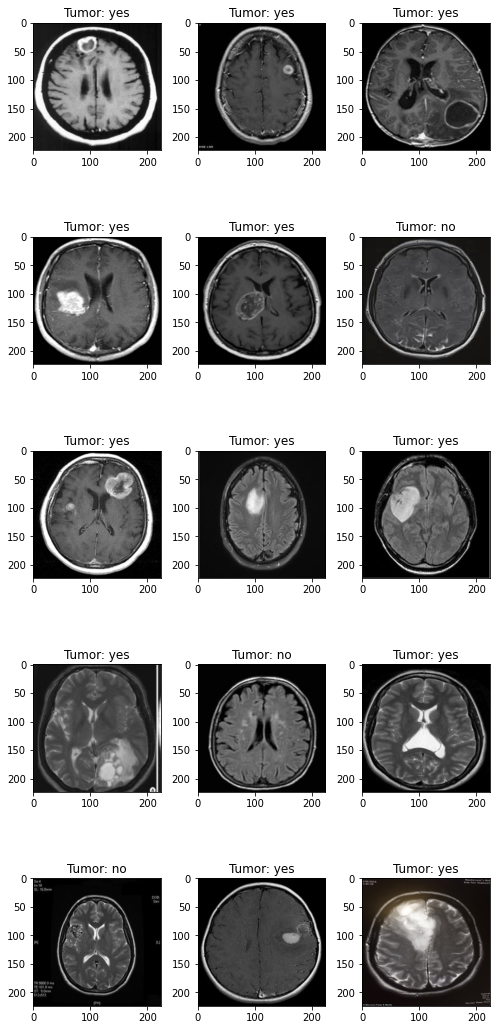

In [0]:
fig,ax=plt.subplots(5,3)
fig.set_size_inches(7,15)
for i in range(5):
  for j in range (3):
    t=np.random.randint(0,len(y_labels))
    ax[i,j].imshow(X[t])
    ax[i,j].set_title('Tumor: '+y_labels[t])


plt.tight_layout()

### 2. Discuss why building a predictive model using this data might be practically useful.  Who could benefit from a model like this? Explain.

Predictive modeling is essential for many forms of aritificial intelligence. Logical operating and decision making relies on trhe ability to ingest data and make a decision, whether that is along a binary axis or about many potential outcomes. Doctors who don't have enough time to take an x-ray or ct scan to a radiologist can benifit, or people making robots to operate with out supervision can as well. 


### 3. Run at least three prediction models to try to predict brain tumor MRI images well. 
### Use transfer learning for at least one of these models 
### Discuss which models performed better and point out relevant hyper-parameter values for successful models.

###**Squeezenet**

In [61]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.20,random_state=42)


y_train 

,no,yes
38,0,1
143,0,1
84,0,1
55,0,1
217,1,0
...,...,...
106,0,1
14,0,1
92,0,1
179,1,0


In [0]:
with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.

  def fire(x, squeeze, expand):
    y  = tf.keras.layers.Conv2D(filters=squeeze, kernel_size=1, activation='relu', padding='same')(x)
    y = tf.keras.layers.BatchNormalization()(y)
    y1 = tf.keras.layers.Conv2D(filters=expand//2, kernel_size=1, activation='relu', padding='same')(y)
    y1 = tf.keras.layers.BatchNormalization()(y1)
    y3 = tf.keras.layers.Conv2D(filters=expand//2, kernel_size=3, activation='relu', padding='same')(y)
    y3 = tf.keras.layers.BatchNormalization()(y3)
    return tf.keras.layers.concatenate([y1, y3])

  def fire_module(squeeze, expand):
    return lambda x: fire(x, squeeze, expand)

  x = tf.keras.layers.Input(shape=[224,224, 3]) # input is 192x192 pixels RGB

  y = tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same',  activation='relu')(x)
  y = tf.keras.layers.BatchNormalization()(y)
  y = fire_module(24, 48)(y)
  y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
  y = fire_module(48, 96)(y)
  y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
  y = fire_module(64, 128)(y)
  y = tf.keras.layers.GlobalAveragePooling2D()(y)
  y = tf.keras.layers.Dense(2, activation='softmax')(y)
  model = tf.keras.Model(x, y)

  model.compile(
    optimizer='adam',
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])

  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc']) 

  model.fit(X_train, y_train, 
                    epochs = 5, verbose=1,validation_data=(X_test,y_test))

Epoch 1/5
7/7 [==============================] - 48s 7s/step - loss: 0.5609 - acc: 0.6931 - val_loss: 0.6910 - val_acc: 0.5294
Epoch 2/5
7/7 [==============================] - 51s 7s/step - loss: 0.5423 - acc: 0.7921 - val_loss: 0.6946 - val_acc: 0.5294
Epoch 3/5
7/7 [==============================] - 48s 7s/step - loss: 0.4728 - acc: 0.8020 - val_loss: 0.7029 - val_acc: 0.5294
Epoch 4/5
7/7 [==============================] - 48s 7s/step - loss: 0.4455 - acc: 0.8119 - val_loss: 0.7172 - val_acc: 0.5294
Epoch 5/5
7/7 [==============================] - 48s 7s/step - loss: 0.4393 - acc: 0.8218 - val_loss: 0.7480 - val_acc: 0.5294


In [0]:
# Now we can extract some evaluative metrics to use for model submission

import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
import pandas as pd
from math import sqrt

def model_eval_metrics(y_true, y_pred,classification="TRUE"):
     if classification=="TRUE":
        accuracy_eval = accuracy_score(y_true, y_pred)
        f1_score_eval = f1_score(y_true, y_pred,average="macro",zero_division=0)
        precision_eval = precision_score(y_true, y_pred,average="macro",zero_division=0)
        recall_eval = recall_score(y_true, y_pred,average="macro",zero_division=0)
        mse_eval = 0
        rmse_eval = 0
        mae_eval = 0
        r2_eval = 0
        metricdata = {'accuracy': [accuracy_eval], 'f1_score': [f1_score_eval], 'precision': [precision_eval], 'recall': [recall_eval], 'mse': [mse_eval], 'rmse': [rmse_eval], 'mae': [mae_eval], 'r2': [r2_eval]}
        finalmetricdata = pd.DataFrame.from_dict(metricdata)
     else:
        accuracy_eval = 0
        f1_score_eval = 0
        precision_eval = 0
        recall_eval = 0
        mse_eval = mean_squared_error(y_true, y_pred)
        rmse_eval = sqrt(mean_squared_error(y_true, y_pred))
        mae_eval = mean_absolute_error(y_true, y_pred)
        r2_eval = r2_score(y_true, y_pred)
        metricdata = {'accuracy': [accuracy_eval], 'f1_score': [f1_score_eval], 'precision': [precision_eval], 'recall': [recall_eval], 'mse': [mse_eval], 'rmse': [rmse_eval], 'mae': [mae_eval], 'r2': [r2_eval]}
        finalmetricdata = pd.DataFrame.from_dict(metricdata)
     return finalmetricdata



In [0]:
# using predict_classes() for multi-class data to return predicted class index.


def predict_classes(x): # adjusted from keras github code
  proba=x
  if proba.shape[-1] > 1:
      return proba.argmax(axis=-1)
  else:
      return (proba > 0.5).astype("int32")

print(predict_classes(model.predict(X_test)))

prediction_index=predict_classes(model.predict(X_test))

#Now lets run some code to get keras to return the label rather than the index...

# get labels from one hot encoded y_train data
labels=pd.get_dummies(y_train).columns

# Iterate through all predicted indices using map method

predicted_labels=list(map(lambda x: labels[x], prediction_index))
print(predicted_labels)

y_test_labels=y_test.idxmax(axis=1)

model_eval_metrics( y_test_labels,predicted_labels,classification="TRUE")

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
['yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes']


,accuracy,f1_score,precision,recall,mse,rmse,mae,r2
0,0.529412,0.346154,0.264706,0.5,0,0,0,0


In [0]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_28 (Conv2D)              (None, 224, 224, 32) 896         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 224, 224, 32) 128         conv2d_28[0][0]                  
__________________________________________________________________________________________________
conv2d_29 (Conv2D)              (None, 224, 224, 24) 792         batch_normalization[0][0]        
______________________________________________________________________________________________

Squeezenets expand tabular data into large matricies with tons of paramaters and then shrinks them down, thereby quickly determining patterns without needing to hold these huge number of paramaters within memory. The squeezenet didn't yield very strong results for me, but I may be doing something wrong.

###**Convulutional Neural Network**




In [31]:
with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.

  model = tf.keras.Sequential([
      # input: images of size 192x192x3 pixels (the three stands for RGB channels)    
      tf.keras.layers.Conv2D(kernel_size=3, filters=64, padding='same', activation='relu', input_shape=[224, 224, 3]),
      tf.keras.layers.Conv2D(kernel_size=1, filters=64, padding='same', activation='relu'),
      tf.keras.layers.MaxPooling2D(pool_size=2),
      tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu'),
      tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', activation='relu'),
      tf.keras.layers.MaxPooling2D(pool_size=2),
      tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu'),
      tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', activation='relu'),
      tf.keras.layers.MaxPooling2D(pool_size=2),
      tf.keras.layers.Conv2D(kernel_size=3, filters=16, padding='same', activation='relu'),
      tf.keras.layers.Conv2D(kernel_size=1, filters=8, padding='same', activation='relu'),
      tf.keras.layers.Flatten(),
      # classifying into 2 categories
      tf.keras.layers.Dense(2, activation='softmax') ])
   
  model.compile(
  optimizer="adam", 
  loss= 'categorical_crossentropy',
  metrics=['accuracy'])
    
    # Fitting the CNN to the Training set
  model.fit(X_train, y_train, 
                      epochs = 10, verbose=1,validation_data=(X_test,y_test)) 

Epoch 1/10
7/7 [==============================] - 23s 3s/step - loss: 0.6501 - accuracy: 0.6337 - val_loss: 0.6746 - val_accuracy: 0.5294
Epoch 2/10
7/7 [==============================] - 23s 3s/step - loss: 0.6353 - accuracy: 0.6337 - val_loss: 0.6566 - val_accuracy: 0.5294
Epoch 3/10
7/7 [==============================] - 24s 3s/step - loss: 0.5600 - accuracy: 0.7327 - val_loss: 0.5651 - val_accuracy: 0.7451
Epoch 4/10
7/7 [==============================] - 23s 3s/step - loss: 0.5120 - accuracy: 0.7673 - val_loss: 0.5679 - val_accuracy: 0.7451
Epoch 5/10
7/7 [==============================] - 23s 3s/step - loss: 0.4833 - accuracy: 0.7673 - val_loss: 0.5500 - val_accuracy: 0.7647
Epoch 6/10
7/7 [==============================] - 23s 3s/step - loss: 0.4598 - accuracy: 0.7921 - val_loss: 0.5287 - val_accuracy: 0.7843
Epoch 7/10
7/7 [==============================] - 23s 3s/step - loss: 0.4366 - accuracy: 0.8020 - val_loss: 0.5330 - val_accuracy: 0.7647
Epoch 8/10
7/7 [==================

In [24]:
print(predict_classes(model.predict(X_test)))

prediction_index=predict_classes(model.predict(X_test))

#Now lets run some code to get keras to return the label rather than the index...

# get labels from one hot encoded y_train data
labels=pd.get_dummies(y_train).columns

# Iterate through all predicted indices using map method

predicted_labels=list(map(lambda x: labels[x], prediction_index))
print(predicted_labels)

y_test_labels=y_test.idxmax(axis=1)

modelevalobject = model_eval_metrics( y_test_labels,predicted_labels,classification="TRUE")
modelevalobject

[0 1 1 0 0 1 0 1 1 1 1 0 0 1 1 1 0 1 0 1 0 1 1 0 1 1 0 0 1 0 0 1 1 0 0 1 1
 0 1 1 0 0 0 1 0 1 1 1 1 0 0]
['no', 'yes', 'yes', 'no', 'no', 'yes', 'no', 'yes', 'yes', 'yes', 'yes', 'no', 'no', 'yes', 'yes', 'yes', 'no', 'yes', 'no', 'yes', 'no', 'yes', 'yes', 'no', 'yes', 'yes', 'no', 'no', 'yes', 'no', 'no', 'yes', 'yes', 'no', 'no', 'yes', 'yes', 'no', 'yes', 'yes', 'no', 'no', 'no', 'yes', 'no', 'yes', 'yes', 'yes', 'yes', 'no', 'no']


,accuracy,f1_score,precision,recall,mse,rmse,mae,r2
0,0.784314,0.782979,0.784161,0.782407,0,0,0,0


In [0]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 224, 224, 64)      4160      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 112, 112, 32)      18464     
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 112, 112, 32)      1056      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 56, 56, 32)       

When building a convulitional neural network, deeper algorithims are better at detetcting features in complex images. One layer may pick up a border and another a pattern. Tumors have specific aspects to them that help determine malignancy, so it's very useful to throw in a lot of layers.

### **Convulutiona Neural Network - Trasnference**

In [0]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten
from tensorflow.keras import backend as K

IMG_SHAPE = (224, 224, 3)

base_model = VGG16(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')
base_model.trainable = False

model = Sequential([
  base_model,
   GlobalAveragePooling2D(),
   Dense(2,activation="softmax")
])

with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.

  model.compile(
    optimizer='adam',
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])

  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc']) 

  model.fit(X_train, y_train,
          epochs = 5, verbose=1,validation_data=(X_test,y_test))

Epoch 1/5
7/7 [==============================] - 103s 15s/step - loss: 0.6978 - acc: 0.4653 - val_loss: 0.7295 - val_acc: 0.5294
Epoch 2/5
7/7 [==============================] - 100s 14s/step - loss: 0.6433 - acc: 0.6337 - val_loss: 0.7700 - val_acc: 0.5294
Epoch 3/5
7/7 [==============================] - 100s 14s/step - loss: 0.6381 - acc: 0.6337 - val_loss: 0.7482 - val_acc: 0.5294
Epoch 4/5
7/7 [==============================] - 101s 14s/step - loss: 0.6178 - acc: 0.6337 - val_loss: 0.7063 - val_acc: 0.5294
Epoch 5/5
7/7 [==============================] - 101s 14s/step - loss: 0.6234 - acc: 0.6386 - val_loss: 0.6977 - val_acc: 0.5294


In [0]:
prediction_index=predict_classes(model.predict(X_test))

labels=pd.get_dummies(y_train).columns

predicted_labels=list(map(lambda x: labels[x], prediction_index))

y_test_labels=y_test.idxmax(axis=1) #extract labels from one hot encoded y_test object

model_eval_metrics( y_test_labels,predicted_labels,classification="TRUE")

,accuracy,f1_score,precision,recall,mse,rmse,mae,r2
0,0.529412,0.346154,0.264706,0.5,0,0,0,0


Transference allows some freezing of paramters and then tuning a new model with the frozen paramters.I think this is top introduce new data to the model so that it does not over tune itself.

### Submit your best model to the leader board for the Brain Tumor Diagnostic AI Model Share competition.

In [0]:
! pip3 install keras2onnx
! pip3 install onnxruntime
! pip3 install https://github.com/mikedparrott/aimodelshare/blob/master/aimodelshare-0.0.5.tar.gz?raw=true

In [0]:
import os
os.environ['TF_KERAS'] = '1' # Add this environmental variable whenever you use tensorflow's tf.keras to build your keras model
import onnx

import keras2onnx

from keras2onnx import convert_keras
onx = convert_keras(model, 'my_model.onnx')
with open("my_model.onnx", "wb") as f:
    f.write(onx.SerializeToString())

In [0]:
# Example Model Pre-launched into Model Share Site
apiurl="https://a53yv0xqce.execute-api.us-east-1.amazonaws.com/prod/m"
username = "zivzach"
password = "Sagan2709"

model_filepath="my_model.onnx"   

# New! Assign model object to model argument parameter to submit model architecture to leaderboard.
model=model
# Set aws keys for this project (these keys give you access to collaborate on a single project)

#Importing from object that stores keys so we do not print out keys for others to see.

import pickle
aws_key_password_region = pickle.load( open( "braintumor_modelsubmission_keys.pkl", "rb" ) )

aws_key=aws_key_password_region[0]
aws_password=aws_key_password_region[1]
region=aws_key_password_region[2]

In [33]:
# Submit your model using submit_model() function
# Works with models and preprocessors. 
import aimodelshare as ai

ai.submit_model(model_filepath=model_filepath, model_eval_metrics=modelevalobject,modelobject=model,apiurl=apiurl, username=username, password=password, aws_key=aws_key,aws_password=aws_password, region=region, trainingdata="default",preprocessor_filepath="default",preprocessor="default")


"my_model.onnx" has been loaded to version 44 of your prediction API.
This version of the model will be used by your prediction api for all future predictions automatically.
If you wish to use an older version of the model, please reference the getting started guide at aimodelshare.com.


In [34]:
import aimodelshare as ai

leaderboard = ai.get_leaderboard(apiurl, username, password, aws_key, aws_password, region)

,accuracy,f1_score,precision,recall,mse,rmse,mae,r2,username,model_version,avg_ranking_classification,avg_ranking_regression,model_config,model_optim_config,model_epochs
15,0.941176,0.940812,0.942547,0.939815,0,0,0,0,Taketo,17,1.000000,1.0,backend: tensorflow\nclass_name: Sequential\nc...,"{'name': 'Adam', 'learning_rate': 0.001, 'deca...",5
14,0.901961,0.901354,0.902950,0.900463,0,0,0,0,Taketo,16,2.000000,1.0,backend: tensorflow\nclass_name: Sequential\nc...,"{'name': 'Adam', 'learning_rate': 0.001, 'deca...",10
16,0.875000,0.868718,0.868718,0.868718,0,0,0,0,3scman,18,3.333333,1.0,backend: tensorflow\nclass_name: Sequential\nc...,"{'name': 'Adam', 'learning_rate': 0.01, 'decay...",25
21,0.862745,0.862745,0.865741,0.865741,0,0,0,0,dhoward97,24,4.333333,1.0,backend: tensorflow\nclass_name: Sequential\nc...,"{'name': 'Adam', 'learning_rate': 1.5625e-05, ...",25
23,0.862745,0.862534,0.862308,0.863426,0,0,0,0,seanmcalevey,26,5.000000,1.0,backend: tensorflow\nclass_name: Sequential\nc...,"{'name': 'SGD', 'learning_rate': 0.001, 'decay...",50
17,0.823529,0.813187,0.875000,0.812500,0,0,0,0,AlisaAi,19,5.333333,1.0,backend: tensorflow\nclass_name: Sequential\nc...,"{'name': 'Adam', 'learning_rate': 0.001, 'deca...",25
20,0.843137,0.841615,0.845611,0.840278,0,0,0,0,seanmcalevey,23,6.000000,1.0,backend: tensorflow\nclass_name: Sequential\nc...,"{'name': 'SGD', 'learning_rate': 0.001, 'decay...",25
32,0.823529,0.791458,0.811776,0.779412,0,0,0,0,ccabelloe,41,8.000000,1.0,backend: tensorflow\nclass_name: Sequential\nc...,"{'name': 'SGD', 'learning_rate': 0.001, 'decay...",25
31,0.823529,0.791458,0.811776,0.779412,0,0,0,0,ccabelloe,40,8.000000,1.0,backend: tensorflow\nclass_name: Sequential\nc...,"{'name': 'SGD', 'learning_rate': 0.001, 'decay...",25
30,0.803922,0.802019,0.805643,0.800926,0,0,0,0,XU,39,8.666667,1.0,backend: tensorflow\nclass_name: Sequential\nc...,"{'name': 'Adam', 'learning_rate': 0.001, 'deca...",5


### 4. Import the best model from the leader board (whatever the best model is after your final submission)
### Note: Import the model's config and it's optimization config.
### Visualize the model's structure using tf.kera's model.summary() 
### Explain how the model's structure is different from your best model.
### Explain how the model's optimization approach is different from your best model

In [0]:
model_config= leaderboard.loc[16,'model_config'] # model details best model (i.e.-row #1)
model_optim_config= leaderboard.loc[16,'model_optim_config'] # model details best model (i.e.-row #1)

print(model_config)
print(model_optim_config)

backend: tensorflow
class_name: Sequential
config:
  build_input_shape: !!python/object/apply:tensorflow.python.framework.tensor_shape.TensorShape
  - - !!python/object/apply:tensorflow.python.framework.tensor_shape.Dimension [null]
    - !!python/object/apply:tensorflow.python.framework.tensor_shape.Dimension [224]
    - !!python/object/apply:tensorflow.python.framework.tensor_shape.Dimension [224]
    - !!python/object/apply:tensorflow.python.framework.tensor_shape.Dimension [3]
  layers:
  - class_name: Conv2D
    config:
      activation: relu
      activity_regularizer: null
      batch_input_shape: !!python/tuple [null, 224, 224, 3]
      bias_constraint: null
      bias_initializer:
        class_name: Zeros
        config: {}
      bias_regularizer: null
      data_format: channels_last
      dilation_rate: &id001 !!python/tuple [1, 1]
      dtype: float32
      filters: 32
      kernel_constraint: null
      kernel_initializer:
        class_name: GlorotUniform
        config:

In [0]:
from tensorflow.keras.models import model_from_yaml
model = model_from_yaml(model_config)
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 32)      1056      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 32)      9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 32)      1056      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 56, 56, 32)       

I couldn't figure out Taketo's Inception model, so picked the other best model, which has a faster learning rate and tons of layers, it's almost a bigger verion of the what I built with more layers and a faster learning rate.

### 5. Fit the best model from the leader board to training data and evaluate it on test data to complete your report.

In [62]:
from keras import optimizers
import keras
import multiprocessing as mp
mp.set_start_method('spawn', force=True)
with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.

  model = tf.keras.Sequential([
      tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu', input_shape=[224, 224, 3]),
      tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', activation='relu'),
      tf.keras.layers.MaxPooling2D(pool_size=2),
      tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu'),
      tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', activation='relu'),
      tf.keras.layers.MaxPooling2D(pool_size=2),
      tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu'),
      tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', activation='relu'),
      tf.keras.layers.MaxPooling2D(pool_size=2),
      tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu'),
      tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', activation='relu'),
      tf.keras.layers.MaxPooling2D(pool_size=2),
      tf.keras.layers.Conv2D(kernel_size=3, filters=16, padding='same', activation='relu'),
      tf.keras.layers.Conv2D(kernel_size=1, filters=8, padding='same', activation='relu'),
      tf.keras.layers.Flatten(),
      # classifying into 2 categories
      tf.keras.layers.Dense(2, activation='softmax') ])
  adam = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,name='Adam')


  model.compile(
  optimizer=adam,
  loss= 'categorical_crossentropy',
  metrics=['accuracy'])


  model.fit(X_train, y_train, 
                      epochs = 10, verbose=1,validation_data=(X_test,y_test))

Epoch 1/10
7/7 [==============================] - 13s 2s/step - loss: 0.6735 - accuracy: 0.6188 - val_loss: 0.6929 - val_accuracy: 0.5294
Epoch 2/10
7/7 [==============================] - 13s 2s/step - loss: 0.5990 - accuracy: 0.6634 - val_loss: 0.5965 - val_accuracy: 0.7647
Epoch 3/10
7/7 [==============================] - 13s 2s/step - loss: 0.6224 - accuracy: 0.7574 - val_loss: 0.5821 - val_accuracy: 0.7451
Epoch 4/10
7/7 [==============================] - 13s 2s/step - loss: 0.4957 - accuracy: 0.7475 - val_loss: 0.5622 - val_accuracy: 0.7255
Epoch 5/10
7/7 [==============================] - 13s 2s/step - loss: 0.4978 - accuracy: 0.7574 - val_loss: 0.5525 - val_accuracy: 0.7843
Epoch 6/10
7/7 [==============================] - 14s 2s/step - loss: 0.4989 - accuracy: 0.7822 - val_loss: 0.5434 - val_accuracy: 0.7843
Epoch 7/10
7/7 [==============================] - 13s 2s/step - loss: 0.4585 - accuracy: 0.7772 - val_loss: 0.5227 - val_accuracy: 0.7843
Epoch 8/10
7/7 [==================

In [63]:
prediction_index=predict_classes(model.predict(X_test))

#Now lets run some code to get keras to return the label rather than the index...

# get labels from one hot encoded y_train data
labels=pd.get_dummies(y_train).columns

# Iterate through all predicted indices using map method

predicted_labels=list(map(lambda x: labels[x], prediction_index))
print(predicted_labels)

y_test_labels=y_test.idxmax(axis=1)

model_eval_metrics( y_test_labels,predicted_labels,classification="TRUE")

[0 1 1 0 0 1 0 1 1 1 1 0 0 1 1 1 1 1 0 1 0 1 1 1 1 1 0 0 1 0 0 1 1 0 0 1 1
 0 1 1 0 0 0 1 1 1 1 1 0 0 0]
['no', 'yes', 'yes', 'no', 'no', 'yes', 'no', 'yes', 'yes', 'yes', 'yes', 'no', 'no', 'yes', 'yes', 'yes', 'yes', 'yes', 'no', 'yes', 'no', 'yes', 'yes', 'yes', 'yes', 'yes', 'no', 'no', 'yes', 'no', 'no', 'yes', 'yes', 'no', 'no', 'yes', 'yes', 'no', 'yes', 'yes', 'no', 'no', 'no', 'yes', 'yes', 'yes', 'yes', 'yes', 'no', 'no', 'no']


,accuracy,f1_score,precision,recall,mse,rmse,mae,r2
0,0.823529,0.821053,0.828571,0.819444,0,0,0,0


### Github Repo

https://github.com/zivzach/Machine-Learning